# Radar-adjustement for OpenMRG dataset

In [6]:
import sys
import os
sys.path.append(os.path.abspath("../poligrain/src"))
sys.path.append(os.path.abspath("../mergeplg/src"))
sys.path.append(os.path.abspath("../pycomlink/"))


import poligrain as plg
import mergeplg as mrg
import pycomlink as pycml

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

## 1. CML processing using radar wet/dry

In [7]:
# Fetches 8 days from OpenMRG dataset
(
    ds_rad,
    ds_cmls,
    ds_gauges_municp,
    ds_gauge_smhi,
) = plg.example_data.load_openmrg(data_dir="example_data", subset="8d")

ds_cmls = ds_cmls.rename_vars({'R': 'R_example'})
ds_rad = ds_rad.rename({'R':'rainfall_radar'})

File already exists at example_data/openmrg_cml_8d.nc
Not downloading!
File already exists at example_data/openmrg_rad_8d.nc
Not downloading!
File already exists at example_data/openmrg_municp_gauge_8d.nc
Not downloading!
File already exists at example_data/openmrg_smhi_gauge_8d.nc
Not downloading!


### Plot raw time series

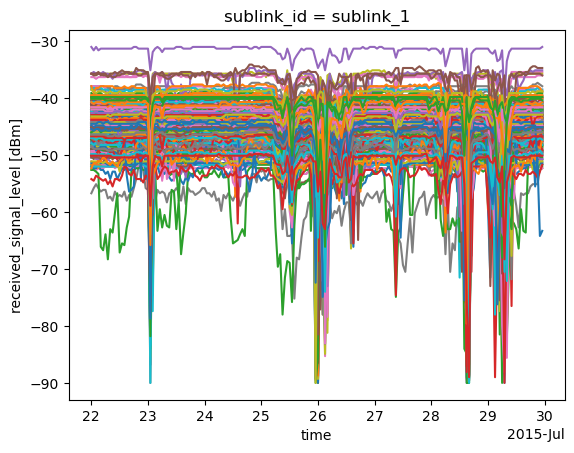

In [8]:
ds_cmls.rsl.isel(sublink_id=0).resample(time='1h').min().plot.line(x='time', add_legend=False);

Text(0.5, 1.0, 'Rain gauges')

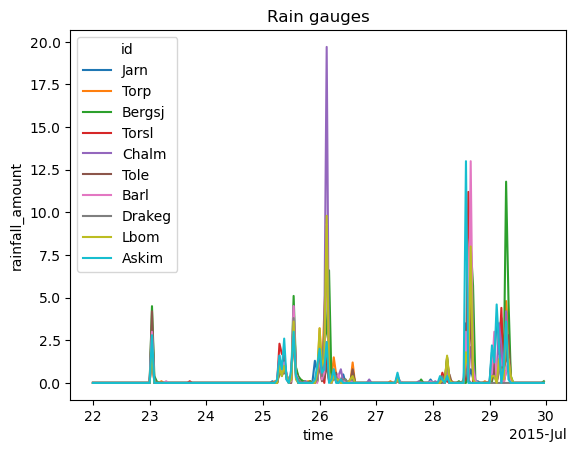

In [22]:
ds_gauges_municp.rainfall_amount.resample(time='1h').sum().plot.line(x='time');
plt.title('Rain gauges')

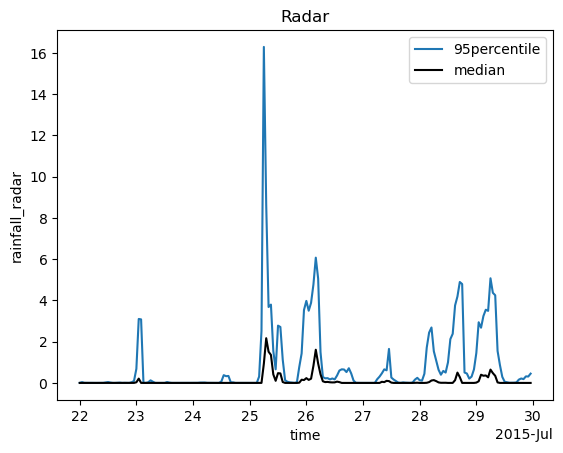

In [23]:
ds_rad.rainfall_radar.resample(time='1h').mean().quantile(q = 0.95, dim=['x', 'y']).plot(color = 'C0', label='95percentile');
ds_rad.rainfall_radar.resample(time='1h').mean().quantile(q = 0.5, dim=['x', 'y']).plot(color = 'k', label='median');
plt.title('Radar')
plt.legend()

### CML preprocessing 

In [24]:
# Select time window for preprocessing
start = "2015-07-25T06:00"
end = "2015-07-25T21:00"
ds_cmls = ds_cmls.sel(time = slice(start, end)).load() # load() speeds up calculations

# Select sublink 0
ds_cmls = ds_cmls.isel(sublink_id = 0)

# Resample CML dataset to 1 minute resolution
ds_cmls = ds_cmls.resample(time = "1min").first(skipna=True)

# calculate total loss
ds_cmls["tl"] = ds_cmls.tsl - ds_cmls.rsl

# Interpolate na
ds_cmls['tl'] = ds_cmls.tl.interpolate_na(dim='time', method='linear', max_gap='5min')

# flag cmls with strong diurnal fluctuation
qc_diurnalcicle = (ds_cmls.tl.rolling(time=60 * 5, center=True).std() > 2).mean(dim="time") > 0.1

# flag cmls with very noisy periods
qc_noisyperiods = (ds_cmls.tl.rolling(time=60, center=True).std() > 0.8).mean(dim="time") > 0.20

ds_cmls.where(qc_diurnalcicle, drop=True);
ds_cmls.where(qc_noisyperiods, drop=True);

### CML processing using radar wet

In [25]:
# Estimate radar along CML
grid_at_lines = plg.spatial.GridAtLines(ds_rad, ds_cmls)

# Radar rainfall rates along CML
da_radar_along_cmls = grid_at_lines(ds_rad.rainfall_radar)

# Resample to sum 1 minute to make comparable to CML
ds_cmls['wet'] = (da_radar_along_cmls > 0.1).rolling(time=3, center=True).max()

In [26]:
# Estimate the baseline during rain events
ds_cmls["baseline"] = pycml.processing.baseline.baseline_constant(
    trsl=ds_cmls.tl,
    wet=ds_cmls.wet,
    n_average_last_dry=5,
)

# compenmsate for wet antenna attenuation
ds_cmls["A_obs"] = ds_cmls.tl - ds_cmls.baseline
ds_cmls["A_obs"] = ds_cmls.A_obs.where(ds_cmls.A_obs >= 0, 0)
ds_cmls["waa"] = pycml.processing.wet_antenna.waa_pastorek_2021_from_A_obs(
    A_obs=ds_cmls.A_obs,
    f_Hz=ds_cmls.frequency * 1e6,
    pol=ds_cmls.polarization.data,
    L_km=ds_cmls.length / 1000,
    A_max=6,
    zeta=0.7,  # 0.55 is default
    d=0.15, # 
)


# calculate attenuation caused by rain and remove negative attenuation
ds_cmls["A"] = ds_cmls.tl - ds_cmls.baseline - ds_cmls.waa
ds_cmls["A"].data[ds_cmls.A < 0] = 0
# derive rain rate via the k-R relation
ds_cmls["R"] = pycml.processing.k_R_relation.calc_R_from_A(
    A=ds_cmls.A,
    L_km=ds_cmls.length.astype(float) / 1000,  # convert to km
    f_GHz=ds_cmls.frequency / 1000,  # convert to GHz
    pol=ds_cmls.polarization,
)


### Plot time series of one CML

## 1. Exercises

- Can you improve the RSD based baseline estimate?

- A downside with radar is that low rainfall rates can result in rapidly changing wet/dry states. Fix this by padding (adding a wet minute close to where the radar already observes rainfall) Hint: Ask an LLM about how to pad numpy arrays and apply this to ds_cmls.wet.

# 2. Interpolate rainfall maps

## 2.1 Prepare example data from poligrain

In [12]:
import sys
import os
sys.path.append(os.path.abspath("../poligrain/src"))
sys.path.append(os.path.abspath("../mergeplg/src"))
sys.path.append(os.path.abspath("../pycomlink/"))


import poligrain as plg
import mergeplg as mrg
import pycomlink as pycml

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

In [13]:
# Fetches 8 days from OpenMRG dataset
(
    ds_rad,
    ds_cmls,
    ds_gauges_municp,
    ds_gauge_smhi,
) = plg.example_data.load_openmrg(data_dir="example_data", subset="8d")

ds_rad = ds_rad.rename({'R':'rainfall_radar'})

File already exists at example_data/openmrg_cml_8d.nc
Not downloading!
File already exists at example_data/openmrg_rad_8d.nc
Not downloading!
File already exists at example_data/openmrg_municp_gauge_8d.nc
Not downloading!
File already exists at example_data/openmrg_smhi_gauge_8d.nc
Not downloading!


In [14]:
# Reduce dataset, selecting 1 hour of data
start = "2015-07-25T13:00"
end = "2015-07-25T14:00"
ds_rad = ds_rad.sel(time = slice(start, end)).load() 
ds_cmls = ds_cmls.sel(time = slice(start, end)).load() 
ds_gauges_municp = ds_gauges_municp.sel(time = slice(start, end)).load() 
ds_gauge_smhi = ds_gauge_smhi.sel(time = slice(start, end)).load() 

In [15]:
# Select sublink 0
ds_cmls = ds_cmls.isel(sublink_id = 0)

# Resample CML dataset to 1 minute resolution
ds_cmls = ds_cmls.resample(time = "1min").first(skipna=True)

### Resample observations to common time resolution

In [16]:
# Resample units of reference data to common 15 minute resolution
da_rad_15_min = (ds_rad.rainfall_radar*5/60).resample(time = '15min', label='right', closed='right').sum() # from mm/h -> sum 5min
da_gauges_municp_15min = ds_gauges_municp.rainfall_amount.resample(time="15min", label='right', closed='right').sum() # from sum 1min -> sum 15min 
da_gauge_smhi_15min = ds_gauge_smhi.rainfall_amount # Already at correct resolution
da_cmls_15min = (ds_cmls.R/60).resample(time = '15min', label='right', closed='right').sum() # from mm/h -> sum 5min

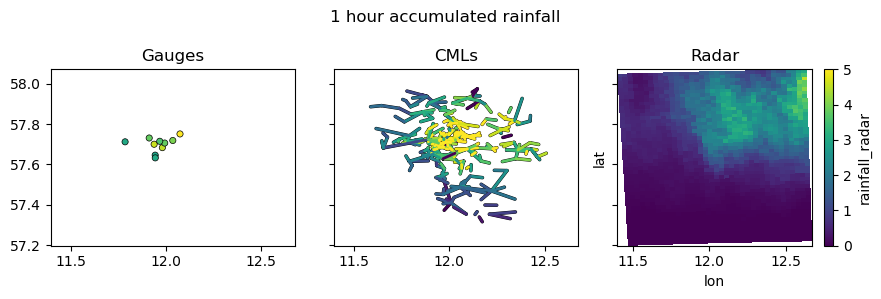

In [17]:
# Plot situation and check that the processed data is similar to example data
fig, ax = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)

plg.plot_map.plot_plg(
    da_gauges=da_gauges_municp_15min.sum(dim="time"),
    use_lon_lat=True,
    vmin=0,
    vmax=5,
    cmap = 'viridis',
    ax=ax[0]
)
plg.plot_map.plot_plg(
    use_lon_lat=True,
    da_cmls=da_cmls_15min.sum(dim = 'time'),
    vmin=0,
    vmax=5,
    cmap = 'viridis',
    ax=ax[1]
)
plg.plot_map.plot_plg(
    da_grid=da_rad_15_min.sum(dim="time"),
    #da_gauges=da_gauges_municp_15min.sum(dim="time"),
    use_lon_lat=True,
    vmin=0,
    vmax=5,
    cmap = 'viridis',
    ax=ax[2]
)
ax[0].set_title('Gauges')
ax[1].set_title('CMLs')
ax[2].set_title('Radar')
fig.suptitle('1 hour accumulated rainfall')
fig.tight_layout()

## 2.2 Interpolate rainfall maps
Rain gauges provide observations at points, while we often want to know the precipitation over an area.

<Axes: >

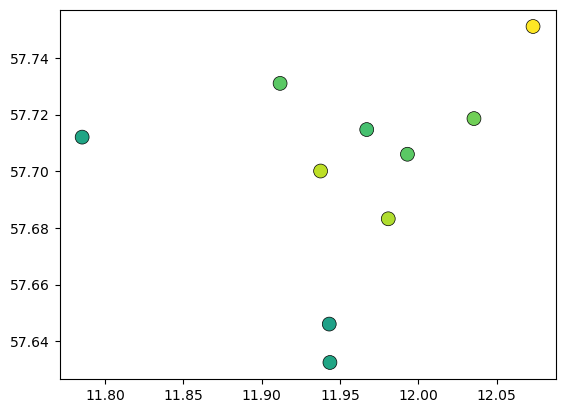

In [18]:
# Same as above, focusing on the rain gauges
plg.plot_map.plot_plg(
    da_gauges=da_gauges_municp_15min.sum(dim="time"),
    use_lon_lat=True,
    vmin=0,
    marker_size=100,# size of dots
    cmap = 'viridis'
)

### Coordinate reference systems
The accurately representation of spatial relationships and distances on a flat plane requires a map projection before interpolating rainfall data.

In [19]:
# Project data to coordinate system
# UTM32N: https://epsg.io/32632
ref_str = "EPSG:32632"

da_gauges_municp_15min.coords["x"], da_gauges_municp_15min.coords["y"] = plg.spatial.project_point_coordinates(
    da_gauges_municp_15min.lon, da_gauges_municp_15min.lat, ref_str
)

# For CML
(
    da_cmls_15min.coords["site_0_x"],
    da_cmls_15min.coords["site_0_y"],
) = plg.spatial.project_point_coordinates(
    da_cmls_15min.site_0_lon, da_cmls_15min.site_0_lat, ref_str
)
(
    da_cmls_15min.coords["site_1_x"],
    da_cmls_15min.coords["site_1_y"],
) = plg.spatial.project_point_coordinates(
    da_cmls_15min.site_1_lon, da_cmls_15min.site_1_lat, ref_str
)

# Midpoint
da_cmls_15min.coords["x"] = (da_cmls_15min.site_0_x + da_cmls_15min.site_1_x) / 2
da_cmls_15min.coords["y"] = (da_cmls_15min.site_0_y + da_cmls_15min.site_1_y) / 2


# Projected radar coords
da_rad_15_min.coords["x_grid"], da_rad_15_min.coords["y_grid"] = (
    plg.spatial.project_point_coordinates(da_rad_15_min.lon, da_rad_15_min.lat, ref_str)
)

### Focus on small area, zoom in on rain gauges

In [20]:
# Get min/max bounds
offset = 4000 # meter
x_min = da_gauges_municp_15min.x.min() - offset
x_max = da_gauges_municp_15min.x.max() + offset
y_min = da_gauges_municp_15min.y.min() - offset
y_max = da_gauges_municp_15min.y.max() + offset

# Select small area radar
da_rad_small = da_rad_15_min.isel(
    x = np.where((da_rad_15_min.x_grid < x_max).any(dim='y') & (da_rad_15_min.x_grid > x_min).any(dim='y'))[0],
    y = np.where((da_rad_15_min.y_grid < y_max).any(dim='x') & (da_rad_15_min.y_grid > y_min).any(dim='x'))[0],
)

# Select small area CML
da_cmls_small = da_cmls_15min.isel(cml_id = np.where(
        (da_cmls_15min.site_0_x < x_max) & (da_cmls_15min.site_1_x < x_max) & 
        (da_cmls_15min.site_0_x > x_min) & (da_cmls_15min.site_1_x > x_min) & 
        (da_cmls_15min.site_0_y < y_max) & (da_cmls_15min.site_1_y < y_max) & 
        (da_cmls_15min.site_0_y > y_min) & (da_cmls_15min.site_1_y > y_min)
    )[0]
)

# Select CMLs longer than 4000 meter
da_cmls_small = da_cmls_small.isel(cml_id = np.where(da_cmls_small.length > 4000)[0])

# Select 3 CMLs of subset
da_cmls_small = da_cmls_small.isel(cml_id = [0, 10, 15])

# Select rain gauges
da_gauges_small = da_gauges_municp_15min

### IDW - Inverse distance weighting


<Axes: >

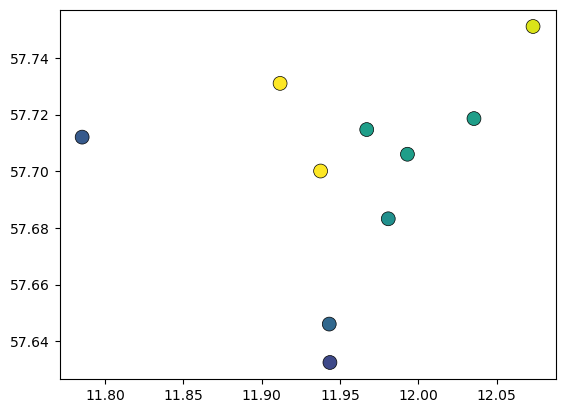

In [21]:
# Plot situation and check that the processed data is similar to example data
t = 3
plg.plot_map.plot_plg(
    da_gauges=da_gauges_municp_15min.isel(time = t),
    use_lon_lat=True,
    vmin=0,
    marker_size=100,# size of dots
    cmap = 'viridis'
)

Goal of IDW: Find weights $\tilde{w_i}$ so that close observations are weighted more
$$
Z(x) = \sum_{i=1}^{n} \tilde{w_i} \cdot Z(x_i)
$$

$$
\tilde{w_i} = \frac{w_i}{\sum_{j=1}^{n} w_j}
$$

where

$$
w_i = d(x, x_i)^{-p}
$$

$$
d(x, x_i) = \sqrt{(x - x_i)^2 + (y - y_i)^2}
$$

#### IDW using mergeplg

In [22]:
# Import interpolator
interpolator = mrg.interpolate.InterpolateIDW()

# Interpolate several timesteps
rainfall_field = []
for time in da_gauges_small.time.data:
    rainfall_field.append(
        # Interpolate 1 timestep
        interpolator.interpolate(
            da_grid = da_rad_small.sel(time = [time]), # Use radar grid coordinates for interpolation
            da_gauge = da_gauges_small.sel(time = [time]), # Data to interpolate, here rain gauges
            p=2, # IDW parameter
            nnear=8, # IDW number of nearest observations to use
        )
    )

# Concat resulting fields
interpolate_idw = xr.concat(rainfall_field, dim="time")

<Axes: title={'center': 'time = 2015-07-25T13:45:00'}, xlabel='lon', ylabel='lat'>

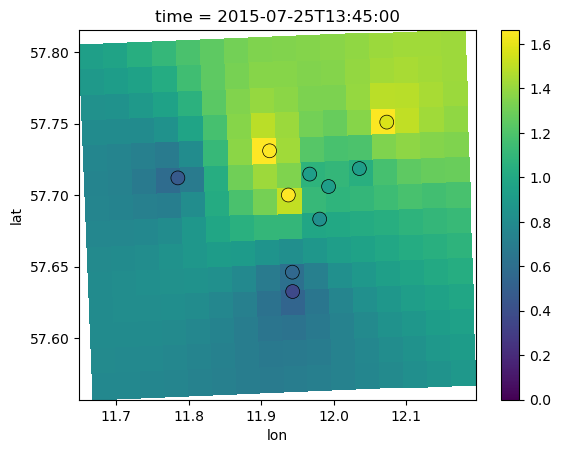

In [23]:
# Plot interpolated field
i = 3
plg.plot_map.plot_plg(
    da_grid=interpolate_idw.isel(time = t),
    da_gauges=da_gauges_municp_15min.isel(time = t),
    use_lon_lat=True,
    vmin=0,
    marker_size=100,
    cmap='viridis'
)

### Exercises IDW
- Set nnear to 2, what happens?
- PLay around with the p-parameter, how does p affect your results? 

## Kriging

### Introduction to Ordinary Kriging

Ordinary Kriging is a geostatistical method used to predict the value of a variable at an unsampled location based on spatial correlation. The key components of Kriging include the variogram, Kriging weights, and the prediction formula.

### Variogram

The variogram $\gamma(h)$ is a function that describes the degree of spatial dependence between samples. It is defined as:

$$
\gamma(h) = \frac{1}{2} \mathrm{Var} \left[ Z(x) - Z(x+h) \right]
$$

where $h$ is the lag distance between two points $x$ and $x+h$.

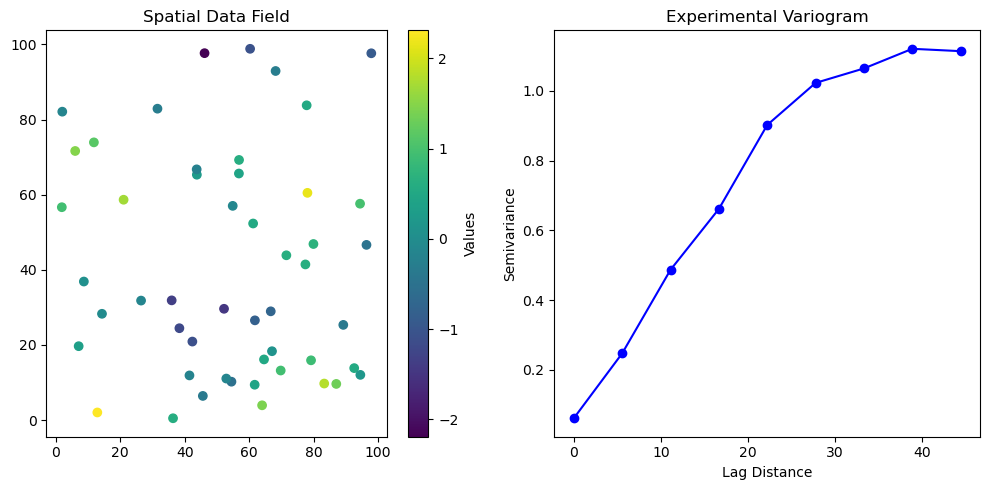

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform

# Generate coordinates
np.random.seed(0)
n_points = 50
x_coords = np.random.uniform(0, 100, n_points)
y_coords = np.random.uniform(0, 100, n_points)

# Spatial function with some noise
values = np.sin(x_coords / 10) + np.cos(y_coords / 10) + np.random.normal(0, 0.2, n_points)

# Compute pairwise distances and variogram
distances = pdist(np.column_stack((x_coords, y_coords)))
semivariances = pdist(values[:, None], metric='sqeuclidean') / 2

# Define lag bins and compute average semivariance per bin
lags = np.linspace(0, 50, 10)
bin_indices = np.digitize(distances, bins=lags)
avg_semivariances = [semivariances[bin_indices == i].mean() for i in range(1, len(lags))]

# Plot
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.scatter(x_coords, y_coords, c=values, cmap='viridis')
plt.colorbar(label='Values')
plt.title('Spatial Data Field')

plt.subplot(122)
plt.plot(lags[:-1], avg_semivariances, 'o-', color='blue')
plt.title('Experimental Variogram')
plt.xlabel('Lag Distance')
plt.ylabel('Semivariance')
plt.tight_layout()
plt.show()



### Kriging Prediction Formula

To predict the value at location $x$ using Ordinary Kriging, we use the following formula:

$$
Z(x) = \sum_{i=1}^{n} \lambda_i Z(x_i)
$$

where $\lambda_i$ are the Kriging weights.

### Kriging Weights Calculation

The Kriging weights $\lambda_i$ are obtained by solving a system of equations based on the variogram values between points.

### System of Equations

The system of equations is represented as:

$$
\begin{bmatrix}
\gamma(x_1, x_1) & \gamma(x_1, x_2) & \cdots & \gamma(x_1, x_n) & 1 \\
\gamma(x_2, x_1) & \gamma(x_2, x_2) & \cdots & \gamma(x_2, x_n) & 1 \\
\vdots & \vdots & \ddots & \vdots & \vdots \\
\gamma(x_n, x_1) & \gamma(x_n, x_2) & \cdots & \gamma(x_n, x_n) & 1 \\
1 & 1 & \cdots & 1 & 0 \\
\end{bmatrix}
\begin{bmatrix}
\lambda_1 \\
\lambda_2 \\
\vdots \\
\lambda_n \\
\mu \\
\end{bmatrix}
=
\begin{bmatrix}
\gamma(x, x_1) \\
\gamma(x, x_2) \\
\vdots \\
\gamma(x, x_n) \\
1 \\
\end{bmatrix}
$$

### Matrix Form

This system can be simplified to a matrix equation:

$$
\mathbf{A} \mathbf{x} = \mathbf{b}
$$

Where:

$$
\mathbf{A} = 
\begin{bmatrix}
\gamma(x_1, x_1) & \gamma(x_1, x_2) & \cdots & \gamma(x_1, x_n) & 1 \\
\gamma(x_2, x_1) & \gamma(x_2, x_2) & \cdots & \gamma(x_2, x_n) & 1 \\
\vdots & \vdots & \ddots & \vdots & \vdots \\
\gamma(x_n, x_1) & \gamma(x_n, x_2) & \cdots & \gamma(x_n, x_n) & 1 \\
1 & 1 & \cdots & 1 & 0 \\
\end{bmatrix}
$$

$$
\mathbf{x} = 
\begin{bmatrix}
\lambda_1 \\
\lambda_2 \\
\vdots \\
\lambda_n \\
\mu \\
\end{bmatrix}
$$

$$
\mathbf{b} = 
\begin{bmatrix}
\gamma(x, x_1) \\
\gamma(x, x_2) \\
\vdots \\
\gamma(x, x_n) \\
1 \\
\end{bmatrix}
$$

The solution is obtained by inverting the matrix $\mathbf{A}$:

$$
\mathbf{x} = \mathbf{A}^{-1} \mathbf{b}
$$


### Kriging in mergeplg

In [25]:
# Import interpolator
interpolator = mrg.interpolate.InterpolateOrdinaryKriging()

# Interpolate several timesteps
rainfall_field = []
for time in da_gauges_small.time.data:
    rainfall_field.append(
        # Interpolate 1 timestep
        interpolator.interpolate(
            da_grid = da_rad_small.sel(time = [time]), # Use radar grid coordinates for interpolation
            da_gauge = da_gauges_small.sel(time = [time]), # Data to interpolate, here rain gauges
            variogram_model = "spherical",
            variogram_parameters = {"sill": 1, "range": 10000, "nugget": 0.1},
            nnear=15
        )
    )

# Concat resulting fields
interpolate_ok = xr.concat(rainfall_field, dim="time")

<Axes: title={'center': 'time = 2015-07-25T13:45:00'}, xlabel='lon', ylabel='lat'>

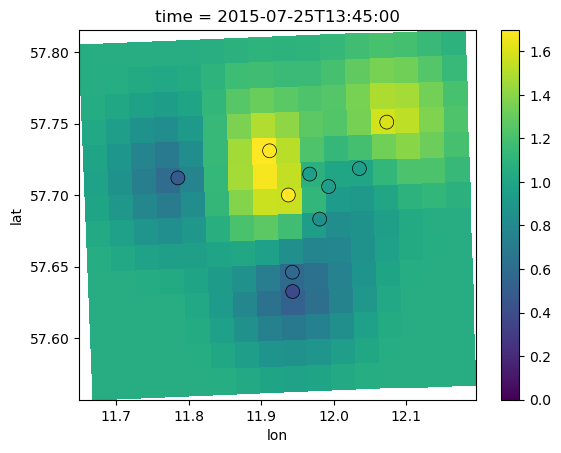

In [26]:
# Plot interpolated field
i = 3
plg.plot_map.plot_plg(
    da_grid=interpolate_ok.isel(time = t),
    da_gauges=da_gauges_municp_15min.isel(time = t),
    use_lon_lat=True,
    vmin=0,
    marker_size=100,
    cmap='viridis'
)

### Exercises ordinary kriging
- What happens if you increase the range of the variogram
- What happens if you increase the nugget of the variogram?

### Interpolate line data - Midpoint
We can interpolate CML data by using the midpoints of the CMLs as reference. 

In [27]:
# Treat CMLs as points
interpolator = mrg.interpolate.InterpolateOrdinaryKriging(min_observations = 2)

# Interpolate several timesteps
rainfall_field = []
for time in da_gauges_small.time.data:
    rainfall_field.append(
        # Interpolate 1 timestep
        interpolator.interpolate(
            da_grid=da_rad_small.sel(time = [time]), # Use radar grid coordinates for interpolation
            da_cml=da_cmls_small.sel(time = [time]),
            variogram_model = "spherical",
            variogram_parameters = {"sill": 1, "range": 8000, "nugget": 0},
            nnear=15,
            full_line=False, # Treat CML data by its midpoint
        )
    )

# Concat resulting fields
interpolate_okm = xr.concat(rainfall_field, dim="time")

<Axes: title={'center': 'time = 2015-07-25T13:45:00'}, xlabel='lon', ylabel='lat'>

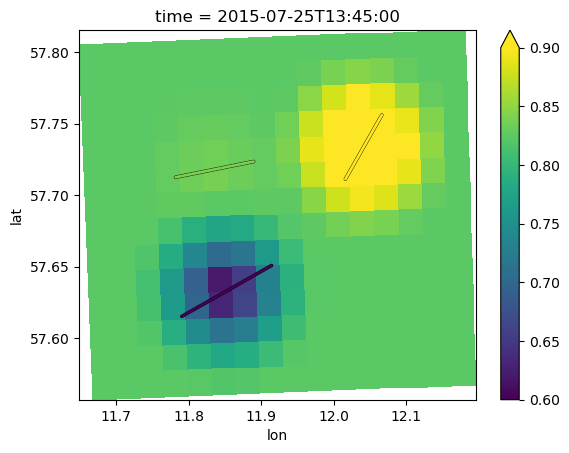

In [28]:
# Plot interpolated field
i = 3
plg.plot_map.plot_plg(
    da_grid=interpolate_okm.isel(time = t),
    da_cmls=da_cmls_small.isel(time = t),
    use_lon_lat=True,
    vmin=0.6,
    vmax=0.9,
    cmap='viridis',
)

### Interpolate line data - Full line
Mergeplg can also handle the full line integral of the CMLs using block kriging.

In [29]:
# Import interpolator
interpolator = mrg.interpolate.InterpolateOrdinaryKriging(min_observations = 2)

# Interpolate several timesteps
rainfall_field = []
for time in da_gauges_small.time.data:
    rainfall_field.append(
        # Interpolate 1 timestep
        interpolator.interpolate(
            da_grid=da_rad_small.sel(time = [time]), # Use radar grid coordinates for interpolation
            da_cml=da_cmls_small.sel(time = [time]),
            variogram_model = "spherical",
            variogram_parameters = {"sill": 1, "range": 8000, "nugget": 0},
            nnear=15,
        )
    )

# Concat resulting fields
interpolate_okb = xr.concat(rainfall_field, dim="time")

<Axes: title={'center': 'time = 2015-07-25T13:45:00'}, xlabel='lon', ylabel='lat'>

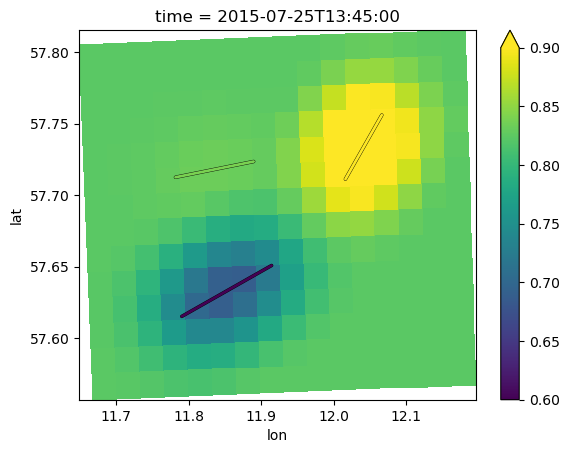

In [30]:
# Plot interpolated field
i = 3
plg.plot_map.plot_plg(
    da_grid=interpolate_okb.isel(time = t),
    da_cmls=da_cmls_small.isel(time = t),
    use_lon_lat=True,
    vmin=0.6,
    vmax=0.9,
    cmap='viridis',
)

### Exercises block kriging
- What happens if you increase the range of the variogram?
- Select longer links (in the code above), how strong is the CML averaging effect? 